# celerite2 not implemented yet!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime

from FIESTA_functions import *
from HARPS_N_functions import *

#----------------------------------
# Read data
#----------------------------------

v_grid  = np.loadtxt('./data_v4/v_grid.txt')
CCF     = np.loadtxt('./data_v4/CCF.txt')
σCCF   = np.loadtxt('./data_v4/σCCF.txt')
bjd     = np.loadtxt('./data_v4/bjd.txt')
rv      = np.loadtxt('./data_v4/rv.txt')
σrv     = np.loadtxt('./data_v4/σrv.txt')
idx_rej = np.array(np.loadtxt('idx_rej'), dtype=bool)

In [2]:
import celerite2
from celerite2 import terms
from scipy.optimize import minimize
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
from datetime import timedelta, date
from datetime import datetime
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days +1)):
        yield start_date + timedelta(n)

In [3]:
date = datetime(2021, 5, 28)
T1 = pyasl.jdcnv(date)
idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
y = rv[idx_bjd] - np.mean(rv[idx_bjd])
reg = LinearRegression().fit(t.reshape((-1, 1)), y)
y = y - reg.predict(t.reshape((-1, 1)))
yerr = σrv[idx_bjd]

In [4]:
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def GP(t, y, yerr):
    w0 = 2*np.pi/6
    Q = 10
    S0 = np.var(y) / (w0 * Q)
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
    kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds)
    # kernel.freeze_parameter("log_omega0")

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    
    return gp


In [5]:
from scipy import stats

def corr(t, y):
    spacing = []
    diff = []
    for i in range(len(t)):
        spacing = np.append(spacing, t[i:]-t[i])
        diff = np.append(diff, y[i:]-y[i])
    return spacing, diff

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    if np.all(weights==0):
        average = 0
        variance = 0
    else:
        average = np.average(values, weights=weights)
        variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

def moving_std(array_x, array_y, width):
    w_aves = []
    w_stds = []
    for t_i in array_x:
        # weights = stats.norm.pdf(array_x, t_i, width)
        weights = np.multiply(abs(array_x-t_i)<width, 1) 
        w_ave, w_std = weighted_avg_and_std(array_y, weights)
        w_aves.append(w_ave)
        w_stds.append(w_std)
    return np.array(w_aves), np.array(w_stds)

In [9]:
def ts_statistics(t, y, yerr):
    gp = GP(t, y, yerr)

    ###############
    # time series #
    ###############
    fig = plt.figure(figsize=(18, 3))
    plt.subplots_adjust(right=0.85, hspace=0.3)
    plt.rcParams.update({'font.size': 14})

    ## Upper panel    
    # plt.title(str(date)[:10])
    plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
    x = np.linspace(min(t), max(t), 1000)
    pred_mean, pred_var = GP(t, y, yerr).predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)        
    plt.plot(x, pred_mean, color='r', alpha=0.3)
    plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='r', alpha=0.1,
                     edgecolor="none")
    plt.xlabel("Time [min]")
    plt.ylabel("RV [m/s]")

    ## Correlation statistics
    fig = plt.figure(figsize=(18, 3))
    spacing, diff = corr(t, y)
    plt.plot(spacing, diff, 'k.', alpha=0.3)        
    plt.xlabel(r'$\Delta$T [min]')
    plt.ylabel(r'$\Delta$RV [m/s]')

    plt.show()

    
    w_ave, w_std = moving_std(spacing, diff, width=0.02)
    
    ###################
    # Plot statistics #
    ###################
    fig = plt.figure(figsize=(18, 3))
    plt.title('all data')
    plt.plot(spacing, w_std, 'r.', alpha=0.5)
    plt.xlabel(r'$\Delta$T [min]')
    plt.ylabel('std [m/s]')
    # plt.plot(spacing, w_ave, 'b.', alpha=0.5)
    plt.show()

    fig = plt.figure(figsize=(18, 3))
    plt.title('zoom in')
    plt.plot(spacing, diff, 'k.')
    plt.plot(spacing, w_std, 'r.')
    plt.xlabel(r'$\Delta$T [min]')
    plt.ylabel('std [m/s]')
    plt.xlim(1.5,1.6)

    fig = plt.figure(figsize=(18, 3))
    plt.title('zoom out')
    plt.plot(spacing, diff, 'k.')
    plt.plot(spacing, w_std, 'r.')
    plt.xlabel(r'$\Delta$T [min]')
    plt.ylabel('std [m/s]')
    # plt.xlim(100, 110)
    plt.xlim(10, 20)
    plt.show()
    
    ###############
    # Periodogram #
    ###############
    from astropy.timeseries import LombScargle

    plt.subplots(figsize=(15, 3))
    plt.rcParams.update({'font.size': 14})
    frequency, power = LombScargle(spacing, w_std).autopower(minimum_frequency=0.1, maximum_frequency=1, samples_per_peak=10)        
    plt.plot(1/frequency, power, 'r', alpha=0.5, label='corr std')
    frequency, power = LombScargle(t, y).autopower(minimum_frequency=0.1, maximum_frequency=1, samples_per_peak=10)
    plt.plot(1/frequency, power, 'k', alpha=0.5, label='time series')
    plt.ylabel('Power')
    plt.xlabel('Period [min]')
    plt.legend()
    plt.show()

    plt.subplots(figsize=(15, 3))
    plt.rcParams.update({'font.size': 14})
    frequency, power = LombScargle(spacing, w_std).autopower(minimum_frequency=0.005, maximum_frequency=1, samples_per_peak=10)        
    plt.plot(1/frequency, power, 'r', alpha=0.5, label='corr std')
    frequency, power = LombScargle(t, y).autopower(minimum_frequency=0.1, maximum_frequency=1, samples_per_peak=10)
    plt.plot(1/frequency, power, 'k', alpha=0.5, label='time series')
    plt.ylabel('Power')
    plt.xlabel('Period [min]')
    plt.legend()
    plt.xscale('log')
    plt.show()

# Test case: y = sin(x)

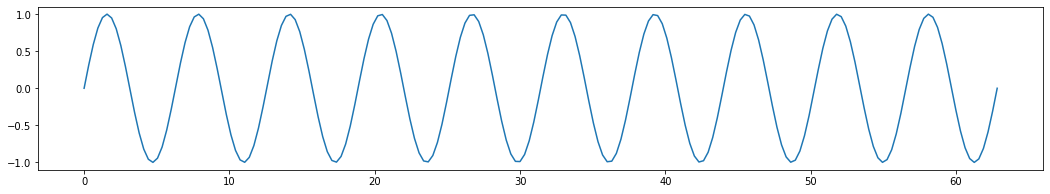

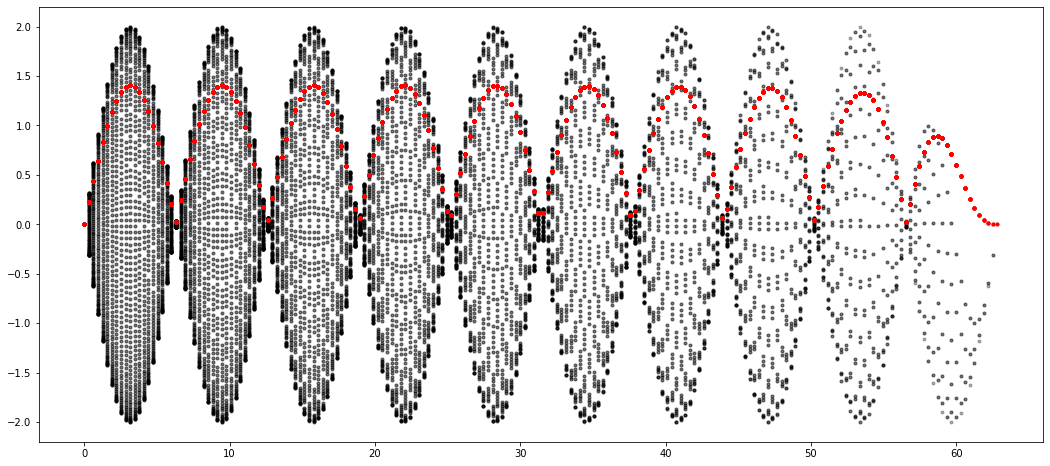

In [10]:
sin_x = np.linspace(0,10*2*np.pi,200)
sin_y = np.sin(sin_x)
delta_y = np.ones(200)*0.01
fig = plt.figure(figsize=(18, 3))
plt.plot(sin_x, sin_y)

spacing, diff = corr(sin_x, sin_y)
fig = plt.figure(figsize=(18, 8))
plt.plot(spacing, diff, 'k.', alpha=0.3)
w_ave, w_std = moving_std(spacing, diff, width=0.25)
plt.plot(spacing, w_std, 'r.')
# plt.plot(t_plot, w_ave, 'b')
# plt.xlim(1,10)
plt.show()

In [11]:
ts_statistics(sin_x, sin_y, delta_y)

ValueError: exactly one of ['w0', 'rho'] must be defined

# NEID Solar RV 

In [ ]:
start_date = datetime(2021, 5, 28)
end_date = datetime(2021, 5, 28)

for date in daterange(start_date, end_date):

    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)
    

    t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
    y = rv[idx_bjd] - np.mean(rv[idx_bjd])
    reg = LinearRegression().fit(t.reshape((-1, 1)), y)
    y = y - reg.predict(t.reshape((-1, 1)))
    yerr = σrv[idx_bjd]        

### one day's RVs

In [ ]:
ts_statistics(t, y, yerr)

### take out the first and last hour of RVs

In [ ]:
ts_statistics(t[40:-40], y[40:-40], yerr[40:-40])
# ts_statistics(t[50:-50], y[50:-50], yerr[50:-50])

# consecutive observations 

In [ ]:
np.diff(t)